## Building Time Series Models to predict the price of gold
---
Project notebook organisation:<br>
**1_ARIMA_Models** (current notebook)<br>
<a href='./2_EDA_and_Preprocessing.ipynb'>2_FaceBook_Prophet</a><br>
<a href='./3_Models.ipynb'>3_VAR</a><br>

---
### This notebook's layout
<a href='#dict'>Data dictionary</a><br>
<a href='#import'>Data Import and Cleaning</a><br>
<a href='#trends'>Exploring Trends</a><br>
<a href='#adf'>Augmented Dickey–Fuller test</a><br>
<a href='#base'>Baseline prediction with SARIMA</a><br>
<a href='#gct'>Granger Causality Test</a><br>
<a href='#sx1'>SARIMAX models (with single exogenous variable)</a><br>
<a href='#sx2'>SARIMAX (with 2 exogenous variables)</a><br>
<a href='#sx3a'>SARIMAX (with 3 exogenous variables, fitted with train data)</a><br>
<a href='#sx3b'>SARIMAX (with 3 exogenous variables, fitted with full data)</a><br>
<a href='#summary'>Summary of Findings</a><br>
<a href='#export'>Export data</a><br>

### Problem statement

With the prevelant of computing, the prediction of any investment assest is a classical problem
The factors that affect the price of any investment assest can be broadly fundatmental or technical depending on the analysis angle or approach. But other factors such as market sentiments, even macro-economics and news could also come into play, making predictions ever as challenging

The basic univariate ARIMA models, in its essence is the prediction of the y target on its x-axis fixed time intervals; based on past x and y values. But its counter part, SARMAIX, enhances the model analysis in two ways: First, by adding seasonal component ; Second, the ability to add external influencing factors know as exgenous variables.
Potentially, making the SARIMAX a better choice as a primarily prediction tool.

“The best model of a cat is a cat”
-Norbert Wiener

In addition , statistician Nate Silver said: “A good model can be useful even when it fails. ‘It should be a given that whatever forecast we make on average will be wrong…So usually it’s about understanding how it’s wrong, and what to do when it’s wrong and minimizing the cost to us when it’s wrong.’ The key is remembering that a model is a tool to help us understand the complexities of the universe, and never a substitute for the universe itself.”

<br> 

In [331]:
import pandas as pd
from pandas.plotting import lag_plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [332]:
%%html
<style>
table {float:left}
</style>

<a id='dict'></a>
### Data dictionary

| Feature           | Description                          | Duration | From | To   | Counts | Source                                        |
| :----------------- | :------------------------------------ | :-------- | :---- | :---- | :------ | :-------------------------------------------- |
| gold_price        | gold  spot price                     | Month    | 1970 | 2020 | 606    | https://www.gold.org/goldhub/data/gold-prices |
| gld               | gold  ETF                            | Day      | 2005 | 2020 | 3880   | yahoo                                         |
| gold_cfd          | gold  cfd                            | Hour     | 2006 | 2020 | 85k    | https://www.quantconnect.com/data/tree        |
| usd_index         | usd relative to basket of currencies | Day      | 2010 | 2020 | 600    | ticker:DX-Y.NYB.  Download from yahoo         |
| fed_interest_rate | interest  rate                       | Month    | 1954 | 2020 | 798    | https://fred.stlouisfed.org/series/FEDFUNDS   |
| us_cpi_inflation  | US  inflation rate                   | Month    | 1947 | 2020 | 888    | https://fred.stlouisfed.org/series/CPIAUCSL   |

<a id='import'></a>
### Data Import and Cleaning

In [333]:
gld = pd.read_csv('../data/gld.csv',parse_dates=['Date'],index_col='Date')
slv = pd.read_csv('../data/slv.csv',parse_dates=['Date'],index_col='Date')

In [334]:
gld = gld[['Close','Volume']]
gld = gld.loc['2016-01-04':]

In [335]:
slv = slv[['Close','Volume']]
slv = slv.loc['2016-01-04':]

In [336]:
print(slv.shape)
print(gld.shape)

(1110, 2)
(1110, 2)


In [337]:
avg_days_in_a_mth_over_5yrs = gld.index.month.value_counts().mean()
no_of_yrs_in_data = len(gld.index.year.unique())
avg_days_in_a_mth = avg_days_in_a_mth_over_5yrs / no_of_yrs_in_data
avg_days_in_a_mth

18.5

In [338]:
print(slv.head(2))
print(gld.tail(2))

            Close   Volume
Date                      
2016-01-04  13.19  4617100
2016-01-05  13.31  3722800
                 Close    Volume
Date                            
2020-05-29  162.910004  12584000
2020-06-01  163.660004   8140200


In [339]:
gld.drop(pd.Timestamp('2020-06-01'),inplace=True)
slv.drop(pd.Timestamp('2020-06-01'),inplace=True)

In [340]:
print(slv.shape)
print(gld.shape)

(1109, 2)
(1109, 2)


In [341]:
gld.columns = ['gld_' + str(col) for col in gld.columns]
slv.columns = ['slv_' + str(col) for col in slv.columns]

In [342]:
df = gld.join(slv)
df.head()

,gld_Close,gld_Volume,slv_Close,slv_Volume
Date,,,,
2016-01-04,102.889999,6440000,13.19,4617100
2016-01-05,103.180000,3500300,13.31,3722800
2016-01-06,104.669998,9316600,13.36,3414700
2016-01-07,106.150001,11730400,13.62,9669500
2016-01-08,105.680000,7678200,13.30,5897700


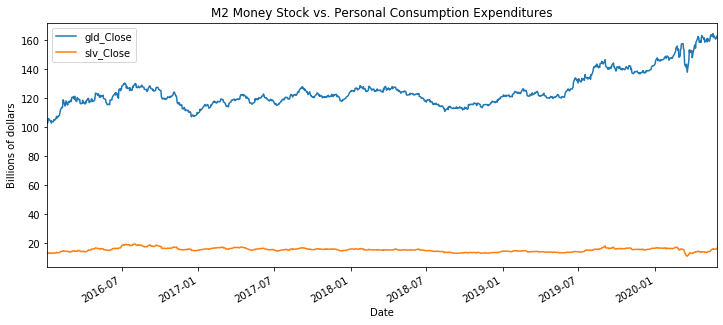

In [343]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['gld_Close'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['slv_Close'].plot(legend=True);

In [252]:
def get_best_gct(gct_output_var, exog_var_name):
    """Returns no. of lags where the p value is lowest"""
    list1=[]
    for nlag in range(1,4,1): # maxlag=3 is standard
        temp_p_value = gct_output_var[nlag][0]['ssr_ftest'][1]
        list1.append(temp_p_value)
    min1 = min(list1) # gets the min value inside list
    min_posn = list1.index(min(list1)) + 1 # Need to plus 1 due to list item length
    print(F'{exog_var_name} minimum P value is {min1} with no.of lag at {min_posn}')

In [253]:
gct_result = grangercausalitytests(gld[['Close','Volume']],maxlag=3,verbose=False);

In [254]:
get_best_gct(gct_result,'USD')

USD minimum P value is 0.2606237060430082 with no.of lag at 1


In [268]:
def adf_test(series):
    """Pass in a time series and an optional title, returns an ADF report"""
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis. Data has a unit root and is non-stationary")

In [269]:
adf_test(gld['Close'])

ADF test statistic        -0.002259
p-value                    0.958345
# lags used               17.000000
# observations          1092.000000
critical value (1%)       -3.436353
critical value (5%)       -2.864190
critical value (10%)      -2.568181
Weak evidence against the null hypothesis
Fail to reject the null hypothesis. Data has a unit root and is non-stationary


In [270]:
adf_test(gld['Volume'])

ADF test statistic     -5.964904e+00
p-value                 1.998444e-07
# lags used             7.000000e+00
# observations          1.102000e+03
critical value (1%)    -3.436298e+00
critical value (5%)    -2.864166e+00
critical value (10%)   -2.568168e+00
Strong evidence against the null hypothesis
Reject the null hypothesis. Data has no unit root and is stationary
